## Day 19 - Relative Strength Index and trading strategy

source : https://www.investopedia.com/terms/r/rsi.asp

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
"""
    :param ticker: closing prices
    :param start: history start date
    :param end: history end date
    :return: stock's historical data 
"""
def get_data(ticker,start="2020-03-25"):
    
    return yf.download(ticker, start)


"""
    :param close: closing prices
    :param length: moving average length
"""
def get_RSI(close,length=20):
    
    # check if the difference is positive or negative
    delta = close.diff(1).dropna()
    
    positive = delta.copy()
    negative = delta.copy()
    
    positive[positive < 0] = 0
    negative[negative > 0] = 0
    
    avg_gain = positive.rolling(window=length).mean()
    avg_loss = abs(negative.rolling(window=length).mean())
    
    rsi = 100 - (100/(1 + avg_gain/avg_loss))
    
    return rsi

In [31]:
stock_history  = get_data('AAPL','2018-03-06')
stock_close = stock_history['Adj Close']

rsi = get_RSI(stock_close,14)

[*********************100%***********************]  1 of 1 completed


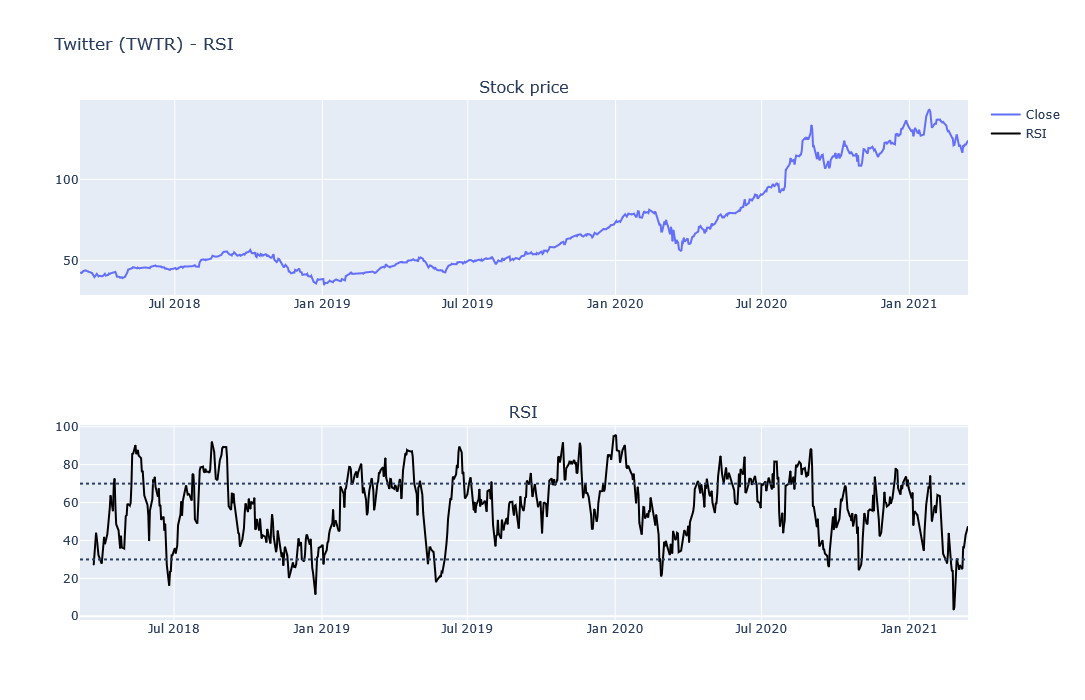

In [32]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("Stock price", "RSI"))

fig.add_trace(go.Scatter(x=stock_close.index, y=stock_close, name='Close'), row=1, col=1)

fig.add_trace(go.Scatter(x=rsi.index, y=rsi, name='RSI',line_color="black"),row=2, col=1)
fig.add_hline(y=30,row=2, col=1, line = dict(dash = 'dot'))
fig.add_hline(y=70,row=2, col=1, line = dict(dash = 'dot'))


fig.update_layout(title_text="Twitter (TWTR) - RSI",height=700)
fig.show()

# static rendering for github
#fig.show("svg")

In [35]:
def trade_RSI(close,lower_bound=30,upper_bound=70,budget=10000):
    
    rsi = get_RSI(close,14)
    
    buy = []
    sell = []
    
    balance = budget 
    traded = 0
    traded_price = 0
    
    # pos = 0 : we do not have any position -> we can buy but we cannot sell
    # pos = 1 : we have a position -> we can sell and we cannot buy 
    
    # I am not considering trading fees
    # I suppose to trade the entire balance 
    pos = 0
    
    # update the profit every time I sell
    # I use another sell_list because I want to know also the final balance If it 
    # is still holding the last position
    sell_dates = []
    profit_values = []
    
    for i in range(1,len(rsi)-1):
        
        # buy
        if pos == 0 and rsi[i] <= lower_bound:
            
            buy.append(i)
            pos = 1
            
            # update balance
            traded_price = close[i]
            traded = balance
            balance = 0
        
        # sell signal
        elif pos == 1 and rsi[i] >= upper_bound:
            sell.append(i)
            pos = 0
            
            # update balance
            balance += traded * (close[i]/traded_price)
            
            # update profit
            sell_dates.append(i)
            profit_values.append(balance-budget)
            
    # final price
    if pos == 1:
        balance += traded * (close[len(close)-1]/traded_price)
        
        # update profit
        sell_dates.append(len(close)-1)
        profit_values.append(balance-budget)
    
    fig = make_subplots(rows=2, cols=1, subplot_titles=("Stock price", "RSI"))
    fig.add_trace(go.Scatter(x=close.iloc[buy].index, y=close.iloc[buy], name='Buy',
                          mode='markers', marker=dict(color='green', size=10, symbol='triangle-up')),row=1, col=1)
    fig.add_trace(go.Scatter(x=close.iloc[sell].index, y=close.iloc[sell], name='Sell',
                            mode='markers', marker=dict(color='red', size=10, symbol='triangle-down')),row=1, col=1)
    fig.add_trace(go.Scatter(x=stock_close.index, y=stock_close, name='Close'), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=rsi.index, y=rsi, name='RSI',line_color="black"), row=2, col=1)
    fig.add_hline(y=30,row=2, col=1, line = dict(dash = 'dot'))
    fig.add_hline(y=70,row=2, col=1, line = dict(dash = 'dot'))
    
    fig.add_trace(go.Scatter(x=rsi.iloc[buy].index, y=rsi.iloc[buy], name='Buy',
                          mode='markers', marker=dict(color='green', size=10, symbol='triangle-up')),row=2, col=1)
    fig.add_trace(go.Scatter(x=rsi.iloc[sell].index, y=rsi.iloc[sell], name='Sell',
                            mode='markers', marker=dict(color='red', size=10, symbol='triangle-down')),row=2, col=1)
    
    fig.show()
    
    return close, balance, sell_dates, profit_values

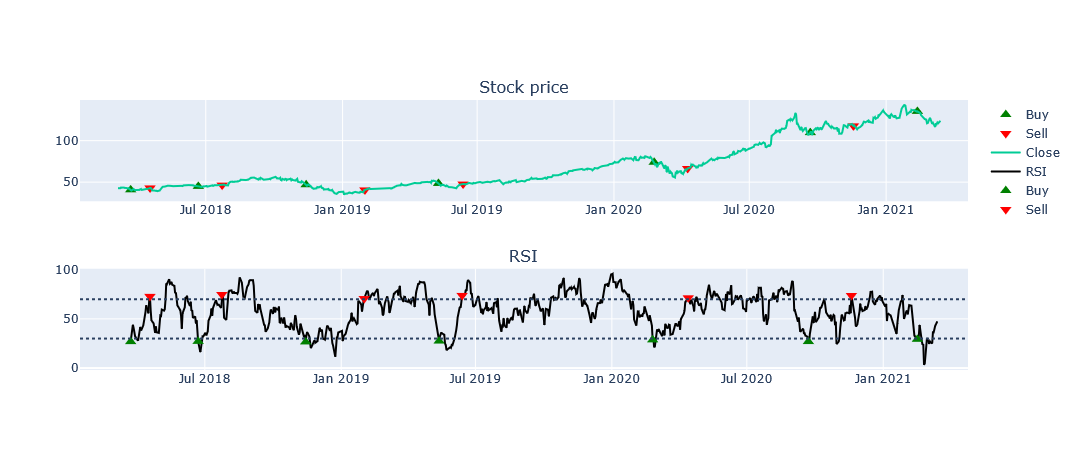

In [40]:
df_signal, balance, sell_dates, profit_values = trade_RSI(stock_close,rsi,lower_bound=30,upper_bound=70,budget=10000)

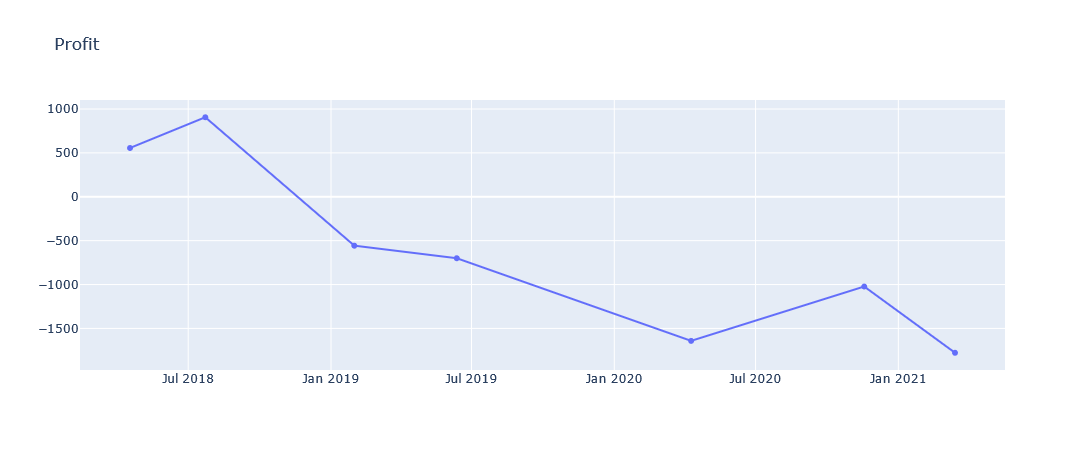

In [41]:
fig_profit = go.Figure()
fig_profit.add_trace(go.Scatter(x=df_signal.iloc[sell_dates].index, y=profit_values, name='profit'))
fig_profit.update_layout(title="Profit")